In [1]:
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt


## Plot the support

In [2]:
struct_L250 = np.loadtxt("runs/U1.1/struct_U1.1J0.5L250.dat", skiprows=1)

<IPython.core.display.Javascript object>


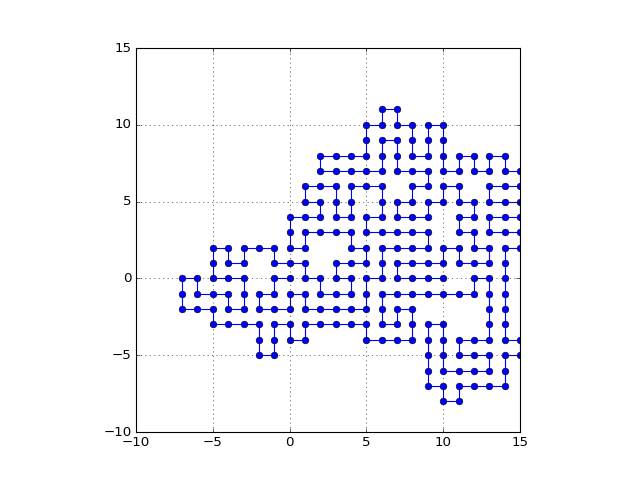

In [3]:
plt.plot(struct_L250[:, 0], struct_L250[:, 1], 'o-')
plt.grid(True)
plt.gca().set_aspect('equal')

<IPython.core.display.Javascript object>


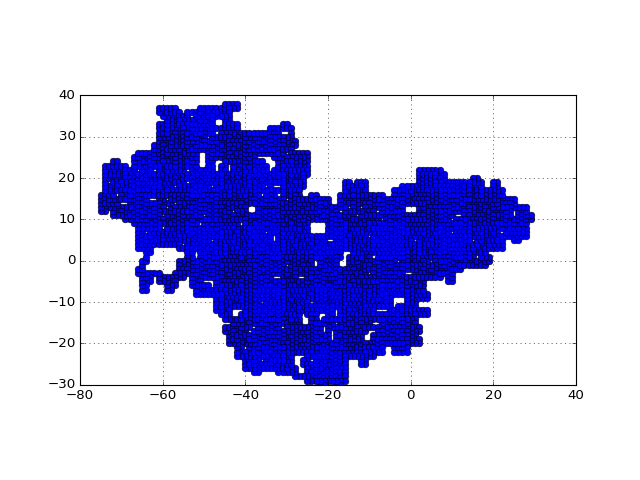

In [5]:
struct_L3600 = np.loadtxt("runs/U1.1/struct_U1.1J0.5L3600.dat", skiprows=1)

plt.plot(struct_L3600[:, 0], struct_L3600[:, 1], 'o-')
plt.grid(True)
plt.gca().set_aspect('equal')

## Ingest magnetization et al

In [6]:
# copy-pasted from ./read_replicas.py

def split_iter(lst, token):
    """Split a list on the token, yield head and tail."""
    idx  = lst.index(token)
    return lst[:idx], lst[idx+1:]


def split_list(lst, token=' -----\n'):
    res = []
    head = lst
    try:
        while True:
            head, tail = split_iter(head, token)
            res.append(head)
            head = tail
    except ValueError:
        # we're done, it seems
        pass
    return res

## test case, trivial
#lst = [1, 2, 3, -1, 4, 5, -1, 6, 7, -1, 8]
#print(split_list(lst, token=-1))

def convert_replica(lst):
    """Parse the lines for a single replica."""
    assert len(lst) == 6
    lst_s = [elem.split('!') for elem in lst]

    r = {}
    for pair in lst_s:
        assert len(pair) == 2
        names = pair[1].strip().split(',')
        values = [float(_) for _ in pair[0].split()]
        for name, val in zip(names, values):
            r[name.strip()] = val

    return r


def read_replica_file(fname, ax=None):
    with open(fname) as f:
        lines = f.readlines()

    # XXX: skip header for now
    str_replicas = split_list(lines)
    str_replicas = str_replicas[1:]

    # convert: replicas will be a list of dicts of {name: value}
    replicas = [convert_replica(str_replica) for str_replica in str_replicas]

    # compute the Binder cumulant
    m2 = np.asarray([_["av_m2"] for _ in replicas])
    err_m2 = np.asarray([_["err_m2"] for _ in replicas])

    m4 = np.asarray([_["av_m4"] for _ in replicas])
    err_m4 = np.asarray([_["err_m4"] for _ in replicas])

    Q = 1. - m4/3.0/m2**2
    err_Q = (2*err_m2 / m2)**2 + (err_m4 / m4)
    err_Q = np.sqrt(err_Q) * Q

    #print("num replicas = ", Q.size)
    #print("Binder Q = ", Q.mean(), Q.std())
    
    if ax is not None:
        plt.hist(Q)
    
    return m2, err_m2, m4, err_m4, Q, err_Q

In [8]:
# {J : Ls}
runs = {0.35 : [450, 850, 1600, 3600],
        0.42 : [450, 850, 1600, 3600, 10000],
        0.45 : [1600, 3600, 10000],
        0.47 : [1600, 3600, 10000],
        0.48 : [1600, 3600, 10000],
        0.5 :  [450, 1600, 3600, 10000],
       }

In [9]:
dt = [('J', float), ('L', int),
      ('m2', float), ('err_m2', float), ('m4', float), ('err_m4', float), ('Q', float), ('err_Q', float)]

arrs = []
for J in runs:
    for L in runs[J]:
        fname = "runs/U1.1/replicas_U1.1J" + str(J) + "L" + str(L) + '.dat'
        m2, err_m2, m4, err_m4, Q, err_Q = read_replica_file(fname)
        arr = np.empty(1, dtype=dt)
        arr['m2'], arr['err_m2'] = m2.mean(), err_m2.mean()
        arr['m4'], arr['err_m4'] = m4.mean(), err_m4.mean()
        arr['Q'], arr['err_Q'] = Q.mean(), np.sqrt((err_Q**2).sum() / err_Q.size)    # FIXME
        arr['J'], arr['L'] = J, L
        arrs.append(arr)
        
df = pd.DataFrame(np.concatenate(arrs))
df

,J,L,m2,err_m2,m4,err_m4,Q,err_Q
0,0.35,450,0.018985,0.000093,0.001039,1.032461e-05,0.043256,0.004360
1,0.35,850,0.010917,0.000068,0.000349,4.535033e-06,0.025262,0.002943
2,0.35,1600,0.006176,0.000050,0.000113,1.928000e-06,0.014054,0.002019
3,0.35,3600,0.002889,0.000034,0.000025,6.243053e-07,0.006824,0.001811
4,0.42,450,0.054610,0.000169,0.007617,4.254953e-05,0.159739,0.012163
5,0.42,850,0.035615,0.000128,0.003413,2.308995e-05,0.114051,0.009560
6,0.42,1600,0.022759,0.000098,0.001444,1.209903e-05,0.078322,0.007281
7,0.42,3600,0.011546,0.000067,0.000386,4.533468e-06,0.040707,0.004491
8,0.42,10000,0.004635,0.000045,0.000064,1.302315e-06,0.015804,0.002459
9,0.45,1600,0.057488,0.000173,0.007982,4.170094e-05,0.207700,0.015361


In [16]:
df[df['L']==10000]

,J,L,m2,err_m2,m4,err_m4,Q,err_Q
8,0.42,10000,0.004635,0.000045,0.000064,0.000001,0.015804,0.002459
11,0.45,10000,0.016859,0.000092,0.000798,0.000008,0.077667,0.008167
14,0.47,10000,0.078974,0.000248,0.013133,0.000067,0.310296,0.022658
17,0.48,10000,0.181797,0.000361,0.050906,0.000152,0.489073,0.027184
21,0.50,10000,0.507993,0.000207,0.269091,0.000179,0.653011,0.016966


<IPython.core.display.Javascript object>


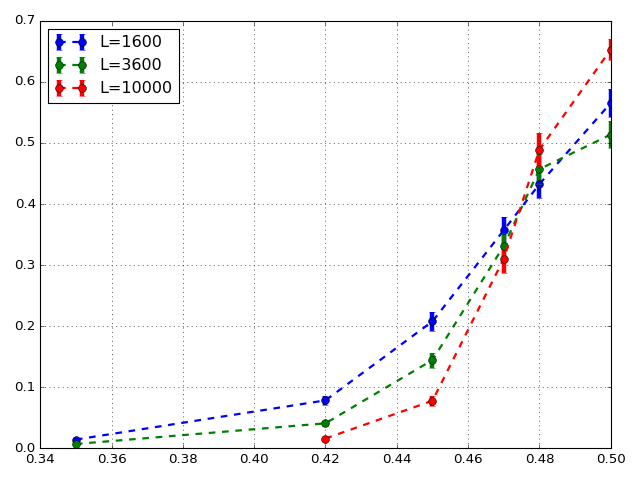

In [10]:
for L in [1600, 3600, 10000]:
    d = df[df['L']==L]
    plt.errorbar(d['J'].values, d['Q'].values, yerr=d['err_Q'].values,
                 fmt='o--', ms=7, elinewidth=4, lw=2, label='L=%s'%L)

plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

In [15]:
d

,J,L,m2,err_m2,m4,err_m4,Q,err_Q
2,0.42,1600,0.022759,0.000098,0.001444,0.000012,0.078322,0.007165
9,0.50,1600,0.330689,0.000335,0.142245,0.000216,0.565468,0.022202


In [17]:
d['J']

2    0.42
9    0.50
Name: J, dtype: float64

# U = 0.8

In [ ]:
# {J : Ls}
runs = {0.4 : [800, 1600, 3600],
        0.45: [800, 1600, 3600, 10000],
        0.5 : [800, 1600, 3600, 10000],
        0.55: [800, 1600, 3600, 10000],
        0.56: [800, 1600, 3600, 10000],
        0.58: [800, 1600, 3600, 10000],
        0.6 : [800, 1600, 3600, 10000],
        0.8 : [800, 1600, 3600], 
        1.0 : [800, 1600, 3600]
       }

dt = [('J', float), ('L', int),
      ('m2', float), ('err_m2', float), ('m4', float), ('err_m4', float), ('Q', float), ('err_Q', float)]

arrs = []
for J in runs:
    for L in runs[J]:
        fname = "runs/U0.8/replicas_U0.8J" + str(J) + "L" + str(L) + '.dat'
        m2, err_m2, m4, err_m4, Q, err_Q = read_replica_file(fname)
        arr = np.empty(1, dtype=dt)
        arr['m2'], arr['err_m2'] = m2.mean(), err_m2.mean()
        arr['m4'], arr['err_m4'] = m4.mean(), err_m4.mean()
        arr['Q'], arr['err_Q'] = Q.mean(), np.sqrt((err_Q**2).sum() / err_Q.size)    # FIXME
        arr['J'], arr['L'] = J, L
        arrs.append(arr)
        
df = pd.DataFrame(np.concatenate(arrs))
df

<IPython.core.display.Javascript object>


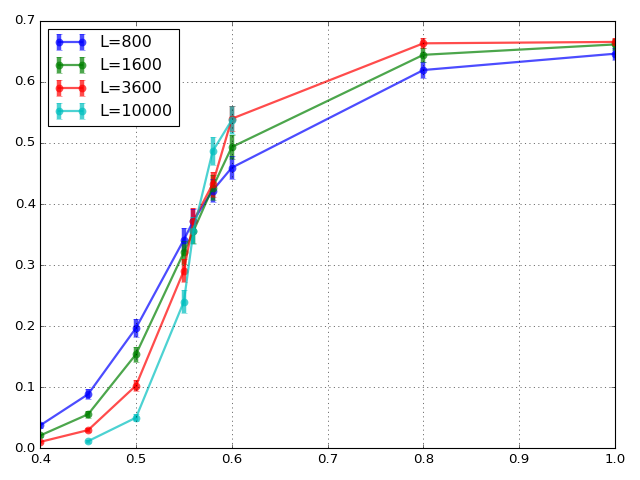

In [12]:
for L in [800, 1600, 3600, 10000]:
    d = df[df['L']==L]
    plt.errorbar(d['J'].values, d['Q'].values, yerr=d['err_Q'].values,
                 fmt='o-', ms=7, elinewidth=4, lw=2, alpha=0.7, mec='none', label='L=%s'%L)

plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

<IPython.core.display.Javascript object>


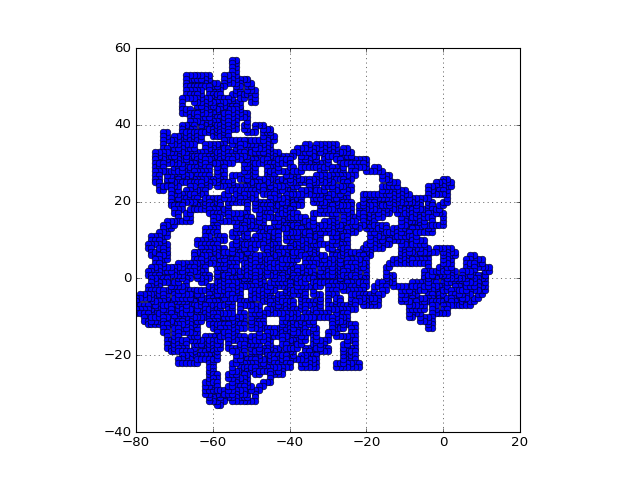

In [13]:
struct_L3600 = np.loadtxt("runs/U0.8/struct_U0.8J0.4L3600.dat", skiprows=1)

plt.plot(struct_L3600[:, 0], struct_L3600[:, 1], 'o-')
plt.grid(True)
plt.gca().set_aspect('equal')

# U = 0.7

In [ ]:
# {J : Ls}
runs = {0.4 : [1600, 3600],
        0.5 : [800, 1600, 3600],
        0.6 : [800, 1600, 3600],
        0.7 : [800, 1600, 3600],
        0.8 : [800, 1600, 3600],
        0.85: [800, 1600, 3600],
        0.9 : [800, 1600, 3600],
       }

dt = [('J', float), ('L', int),
      ('m2', float), ('err_m2', float), ('m4', float), ('err_m4', float), ('Q', float), ('err_Q', float)]

arrs = []
for J in runs:
    for L in runs[J]:
        fname = "runs/U0.7/replicas_U0.7J" + str(J) + "L" + str(L) + '.dat'
        m2, err_m2, m4, err_m4, Q, err_Q = read_replica_file(fname)
        arr = np.empty(1, dtype=dt)
        arr['m2'], arr['err_m2'] = m2.mean(), err_m2.mean()
        arr['m4'], arr['err_m4'] = m4.mean(), err_m4.mean()
        arr['Q'], arr['err_Q'] = Q.mean(), np.sqrt((err_Q**2).sum() / err_Q.size)    # FIXME
        arr['J'], arr['L'] = J, L
        arrs.append(arr)
        
df = pd.DataFrame(np.concatenate(arrs))
df

<IPython.core.display.Javascript object>


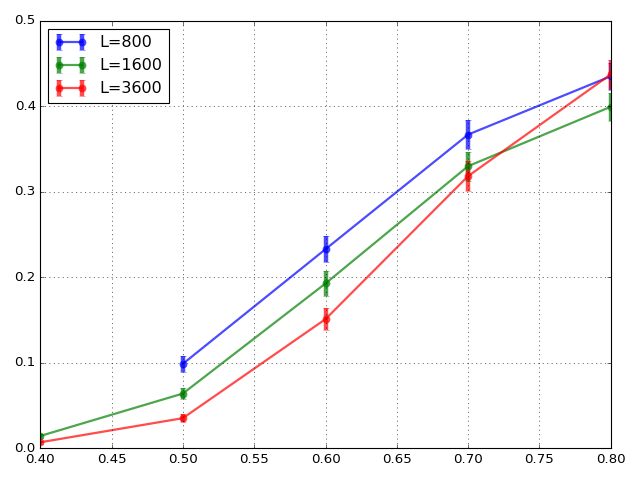

In [26]:
for L in [800, 1600, 3600]:
    d = df[df['L']==L]
    plt.errorbar(d['J'].values, d['Q'].values, yerr=d['err_Q'].values,
                 fmt='o-', ms=7, elinewidth=4, lw=2, alpha=0.7, mec='none', label='L=%s'%L)

plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
struct_L3600 = np.loadtxt("runs/U0.7/struct_U0.7J0.7L3600.dat", skiprows=1)

plt.plot(struct_L3600[:, 0], struct_L3600[:, 1], 'o-')
plt.grid(True)
plt.gca().set_aspect('equal')